## Math 157: Intro to Mathematical Software
## UC San Diego, Winter 2022

### Final project: Wordle and Information Theory by Raghav Maddukuri

# Goal of this lecture:

## Wordle in practice, what is the best starting word?

First things first I need to remake the Julia functions in Python, so here is the code below:

The code cell below is the customary import cell. I also generate all possible combinations for the word information we get back. You can see why I didn't code out the analyzing with if statements in the Julia lecture.

In [1]:
#imports needed for the code
import itertools
from scipy.stats import entropy
from collections import defaultdict, Counter
from matplotlib import pyplot as plt 
import numpy as np 
GUESSES = 10
WORD_FILE_all = "words.txt"
WORD_FILE = "correct_words.txt"

#generates all possible combinations of grey, yellow and green letters, represented as 0,1,2. combinations
all_patterns = list(itertools.product([0,1,2],repeat =5))
len(all_patterns)

243

The code below is for reading in all possible five letter words, and the correct dictionary of words.

In [2]:
orig_all_words = []
f = open('words.txt', "r")
for x in f:
    orig_all_words.append(x[0:5])
all_words = set(orig_all_words)   
correct_words = []
f = open('correct_words.txt', "r")
for x in f:
    correct_words.append(x[0:5])
    


Below we have a helper function that shows us the difference between two input words. It goes through both 5 letter words, determines whether the letter is green, yellow or grey. It does this by using the Counter object from python to store letters in the correct word. Then it goes through the list of letters we found to find if it exists in both letters at all, at the right position. Keep in mind this function in purely for the simulation, as this information, would be something we would normally input.

In [3]:
#returns the difference between guess and real
def get_pattern(guess,real):
    wrong = [i for i,v in enumerate(guess) if v !=real[i]]
    counts = Counter(real[i] for i in wrong)
    pattern = [2,2,2,2,2]
    for i in wrong:
        v = guess[i]
        if counts[v]>0:
            pattern[i] = 1
            counts[v] -=1
        else:
            pattern[i] =0
    return tuple(pattern)

In [5]:
get_pattern('salet','steal')

(2, 1, 1, 1, 1)

This is where we compile a list of all patterns with our input word. This how we create a new pool of active words.

In [4]:
#return a list of combinations between words
def generate_valid(s,d):
    patterns = defaultdict(lambda: defaultdict(set))
    for word2 in d:
        patterns[s][get_pattern(s,word2)].add(word2)
    return dict(patterns)

In [7]:
patterns = generate_valid('crane',['weary',"sears","crane","adieu"])
print(patterns['crane'][2,2,2,2,2])
print(patterns['crane'][0,1,2,0,1])
print(patterns['crane'][0,0,1,0,1])
# print(patterns['weary'][0,0,0,0,1])

{'crane'}
{'sears', 'weary'}
{'adieu'}


In [20]:
pattern = generate_valid('salet',orig_all_words)
print(pattern['salet'][1,1,1,1,1])

{'leats', 'tesla', 'teals'}


This code cell centers on getting the total entropy for a list of words in relation to a given parameter. It shows the frequency of each letter in the word in the active pool of guesses. This is where the data in the histogram of letters comes from. I mainly had scipy do most of the work, so check out the documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

In [5]:
#calc entropies for every word in wrods using total words as the pool
def calc_entropies(words, total_words):
    entropies = {}
    for word in words:
        counts = []
        for pattern in all_patterns:
            matches = generate_valid(word,all_words)[word][pattern]
            matches = matches.intersection(total_words)
            counts.append(len(matches))
        entropies[word]=entropy(counts)
    return entropies

In [22]:
calc_entropies('salet',correct_words)

{'s': 0.4365046890407941,
 'a': 0.22945625477858408,
 'l': 0.16157697703599758,
 'e': 0.13855052742833301,
 't': 0.23880701071780291}

Below is the wordle simulator, given a starter word, and a mystery word it will find the minimum number of guesses to find the mystery letter. 

In [6]:
#Try and pick something that has a higher matching, since the kernel takes forever to run it, like mathcing only an e with a guess of salet for bribe took 2 minutes to compile.
def wordle(mystery,starter):
    MYSTERY_WORD = mystery
    STARTER_WORD = starter
    all_words = set(orig_all_words)
    info = get_pattern(STARTER_WORD,MYSTERY_WORD)
    words = generate_valid(STARTER_WORD,all_words)
    words = words[STARTER_WORD][info]
    all_words = all_words.intersection(words)
    print("The Mystery Word is:", MYSTERY_WORD)
    print('The current guess is : ', STARTER_WORD)
    print("The current matching status is: ", info)


        #took a shortcut b/c it took to long/ I cheated and looked through only the words in the right answer list that matched with our first guess. The only difference would be that choices would be all_words, but Cocalc can't handle 360*~13000.
    choices = generate_valid(STARTER_WORD,correct_words)[STARTER_WORD][info]
    entropies = calc_entropies(choices,all_words)
    for attempt in range(1,GUESSES):
        print("The Mystery Word is:", MYSTERY_WORD)

        if len(all_words) ==1:
            print("Wordle bot guesses:",all_words)
            print("Guessed in this many rounds:", attempt)
            break
        guess_word = max(entropies, key=entropies.get)
        info = get_pattern(guess_word,MYSTERY_WORD)
        print('The current guess is : ', guess_word)
        print("The current matching status is: ", info)
        if guess_word.__eq__(MYSTERY_WORD):
            print("Guessed in this many rounds:", attempt)
            break
        remaining = generate_valid(guess_word,all_words)[guess_word][info]
        all_words = all_words.intersection(remaining)
        entropies = calc_entropies(remaining,all_words)
    return attempt
   

The above code works well, but there are certain limitations. The biggest limitation that I found was where the program had to guess between words that rhymed with one another. IF you look where I wrote my comment, I use a smaller list than what is technically optimal. March 11 is a perfect example of what I mean. "watch" was the answer for the day. I had to bot guess "salet", then its next reccomended, the it guessed patch, then hatch, then finally watch. Luckily, w had a greater entropy value than b or m, so it didn't guess batch or match and lose the game. However this is a limitation. To avoid this potential 50/50, A normal human could guess something like blimp to eliminate most of these options. However, if blimp is not in the correct_words.txt, the program would never guess this to simplify the pool.

In [26]:
#This took about 3 min to run, so be mindful when running it please.
print(wordle("pleat","salet"))

The Mystery Word is: pleat
The current guess is :  salet
The current matching status is:  (0, 1, 1, 1, 2)


The Mystery Word is: pleat
The current guess is :  leapt
The current matching status is:  (1, 1, 1, 1, 2)


The Mystery Word is: pleat
Wordle bot guesses: {'pleat'}
Guessed in this many rounds: 2
2


This is just a visualizer for the data we get back from the simulator.

In [7]:
# Creating histogram
def grapher(x):
    
    plt.hist(x,bins=[i for i in range(0,11,1)],width =1)
    plt.xlabel("X-axis")
    plt.ylabel("y-axis")
    plt.title('distribubion of the starter word')
    
    plt.xticks(np.arange(0,11,step=1))
    
    # Show plot
    plt.show()

# Finding the Best word
## Just run the simulation for every single word combination, and find the one that takes the least average guesses.
Obviously the free version of Cocalc does not have that kind of processing power, so I just took some of my friend's favorite words, the best word "salet", according to 3blue1brown and the two worst in fuzzy, and xylyl.

The average guesses it will take is 3.686868686868687


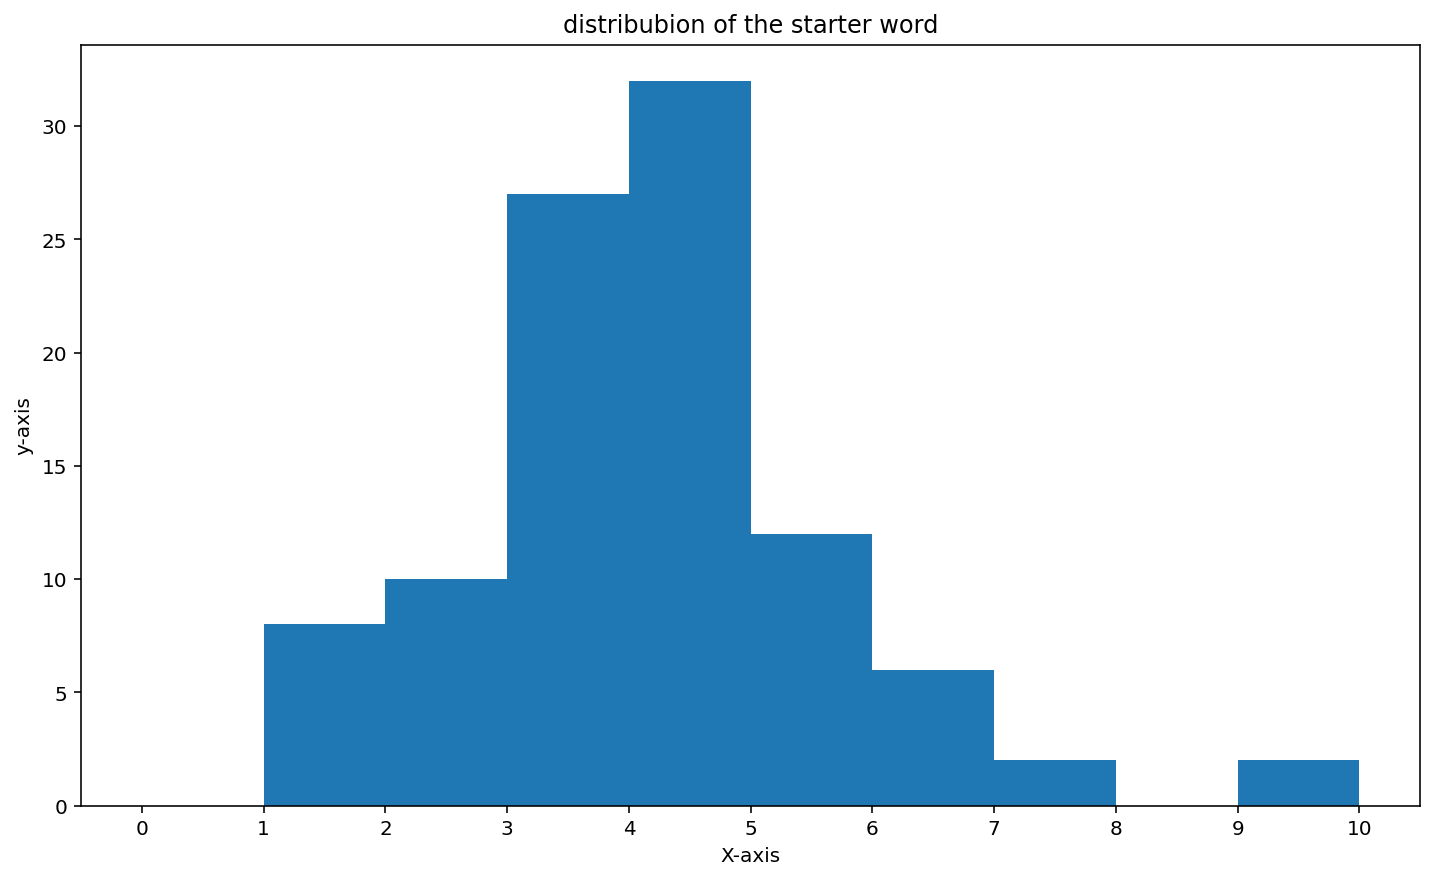

In [79]:
arr = []
for i in range(1,100):
    arr.append(wordle(correct_words[i],'salet'))
print("The average guesses it will take is", sum(arr)/len(arr))
grapher(arr)

The average guesses it will take is 3.686868686868687


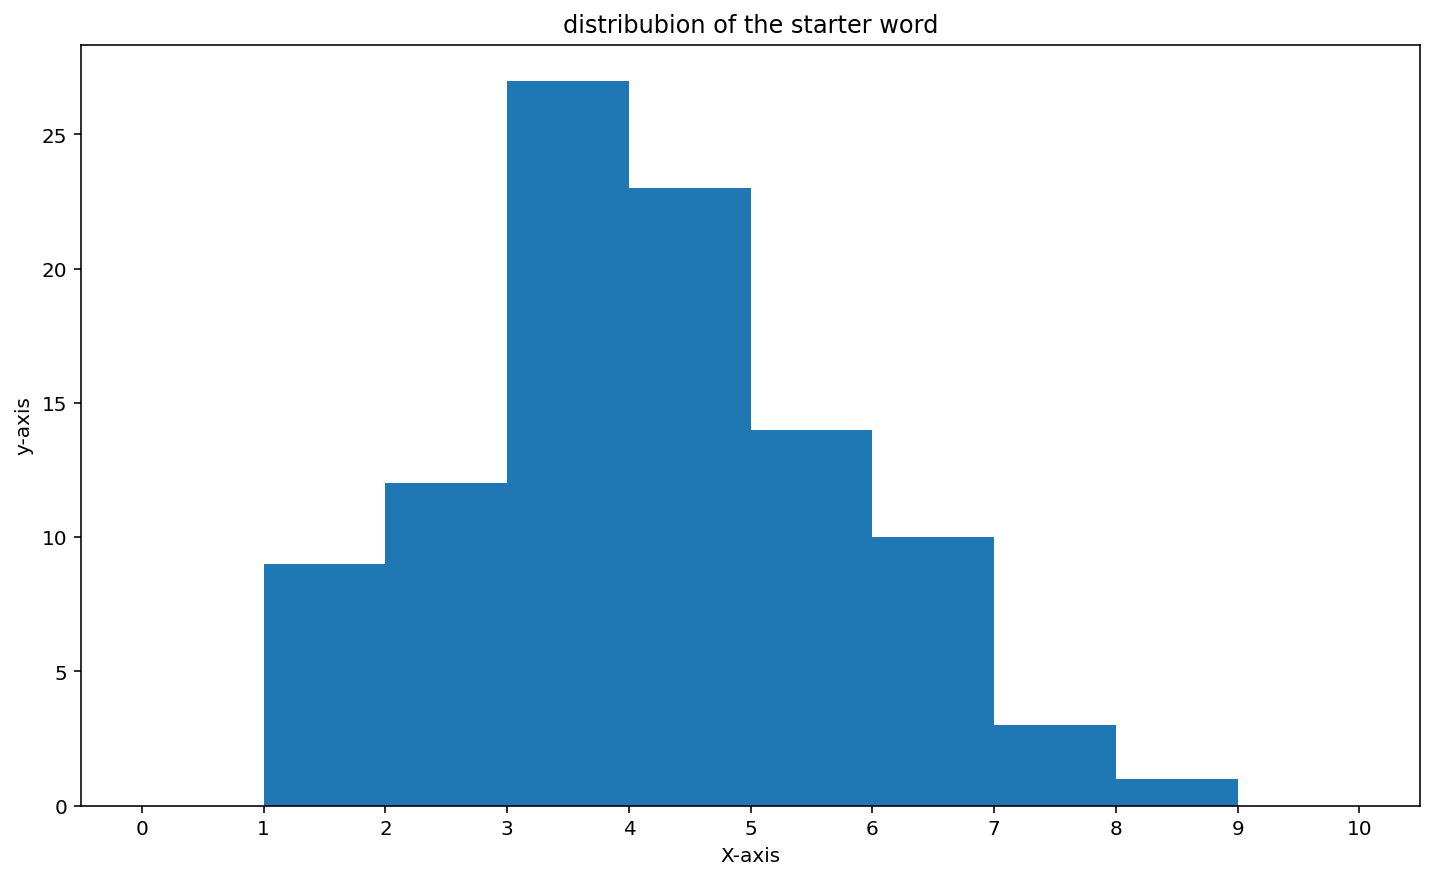

In [80]:
arr = []
for i in range(1,100):
    arr.append(wordle(correct_words[i],'crate'))
print("The average guesses it will take is", sum(arr)/len(arr))
grapher(arr)

The average guesses it will take is 3.6565656565656566


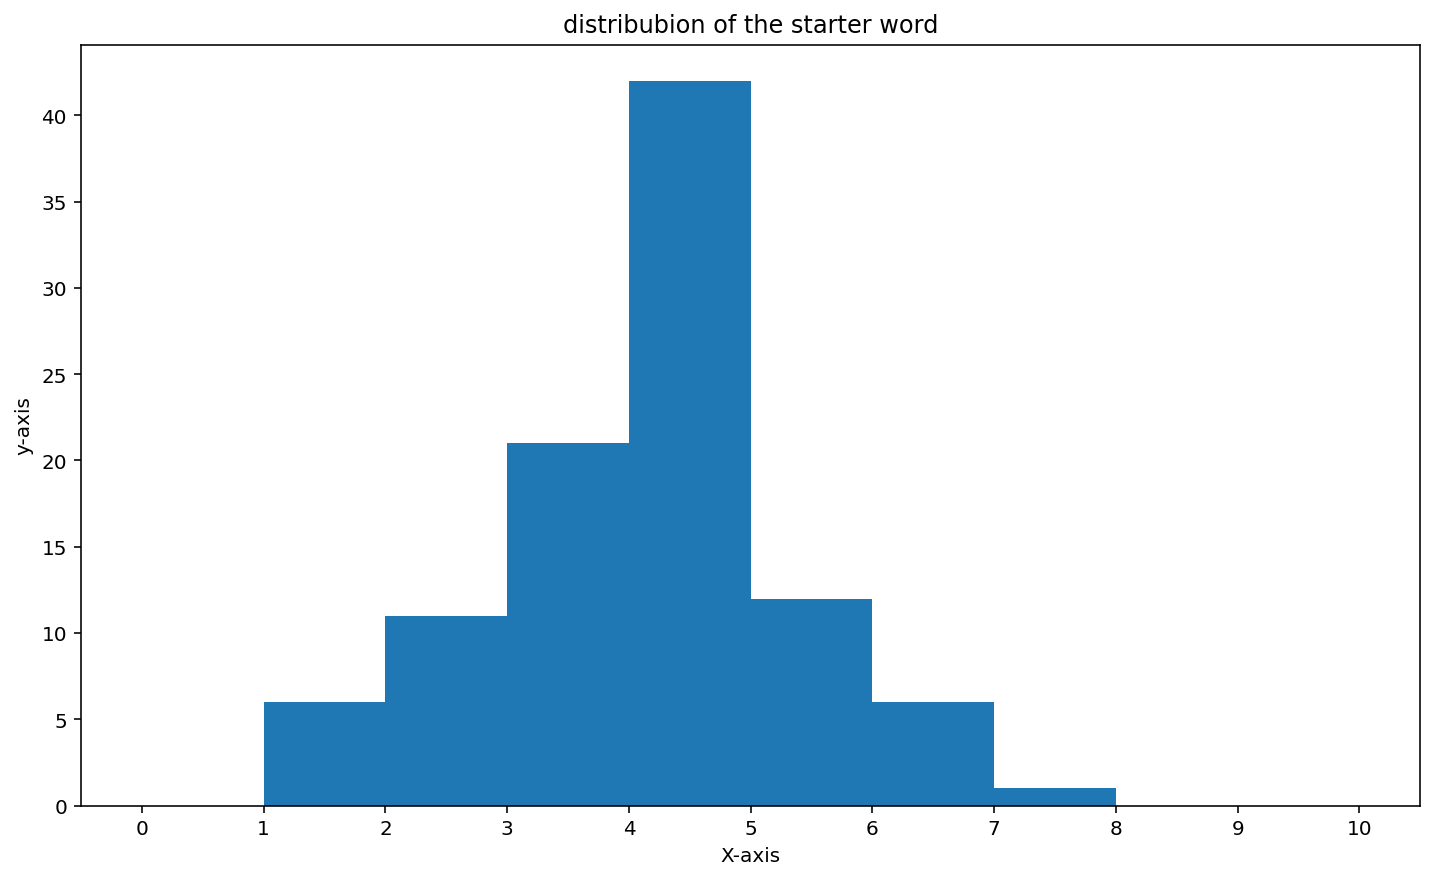

In [81]:
arr = []
for i in range(1,100):
    arr.append(wordle(correct_words[i],'lotus'))
print("The average guesses it will take is", sum(arr)/len(arr))
grapher(arr)

The average guesses it will take is 3.9696969696969697


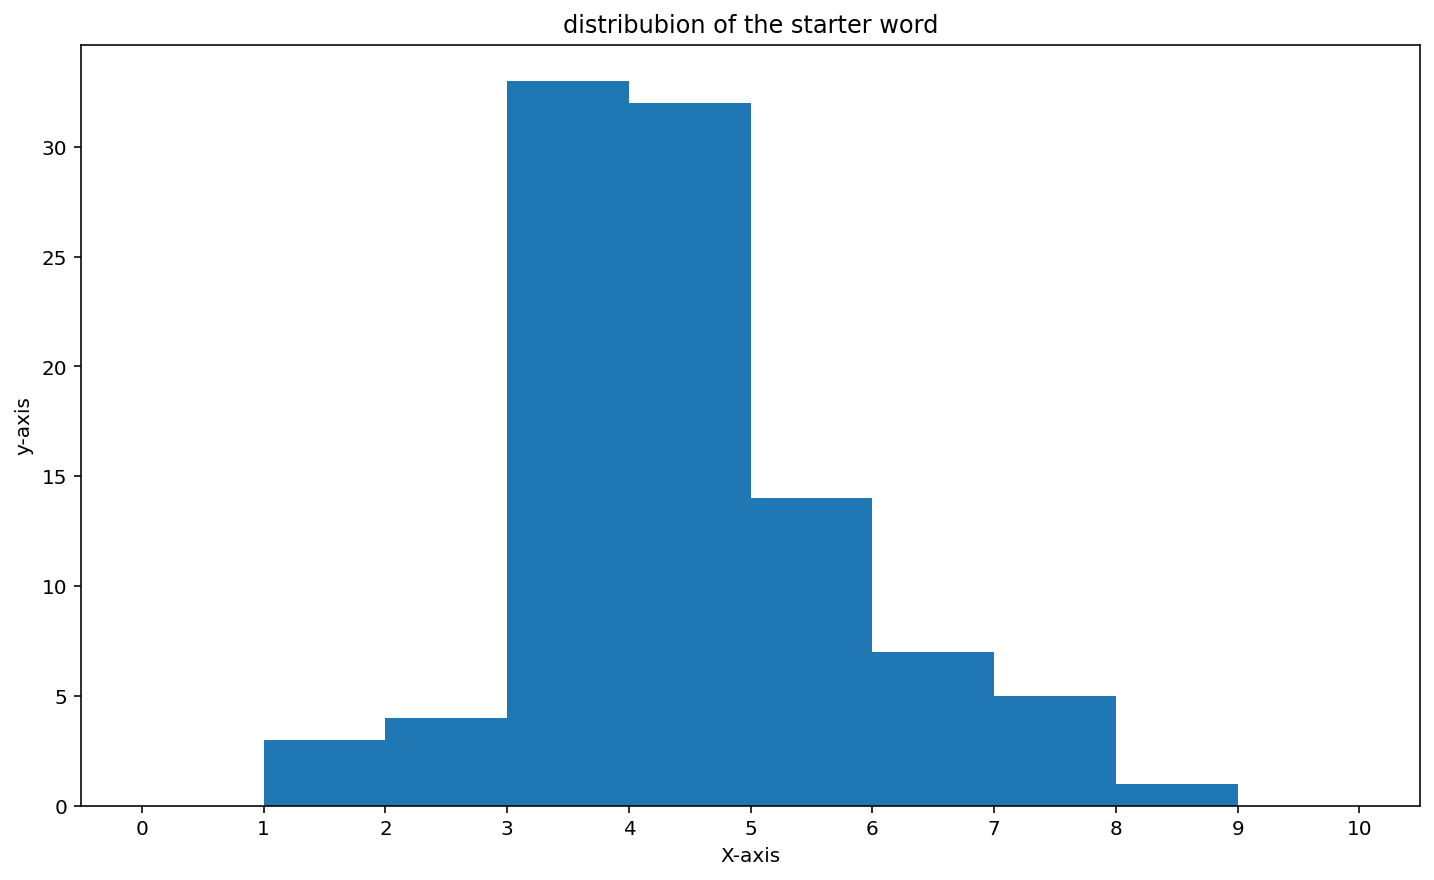

In [82]:
arr = []
for i in range(1,100):
    arr.append(wordle(correct_words[i],'adieu'))
print("The average guesses it will take is", sum(arr)/len(arr))
grapher(arr)

# I do not recommend running these last two code cells as they took me about 5 minutes to compile, they are here to show you the code for determining how much worse the worst word is.

The average guesses it will take is 4.262626262626263


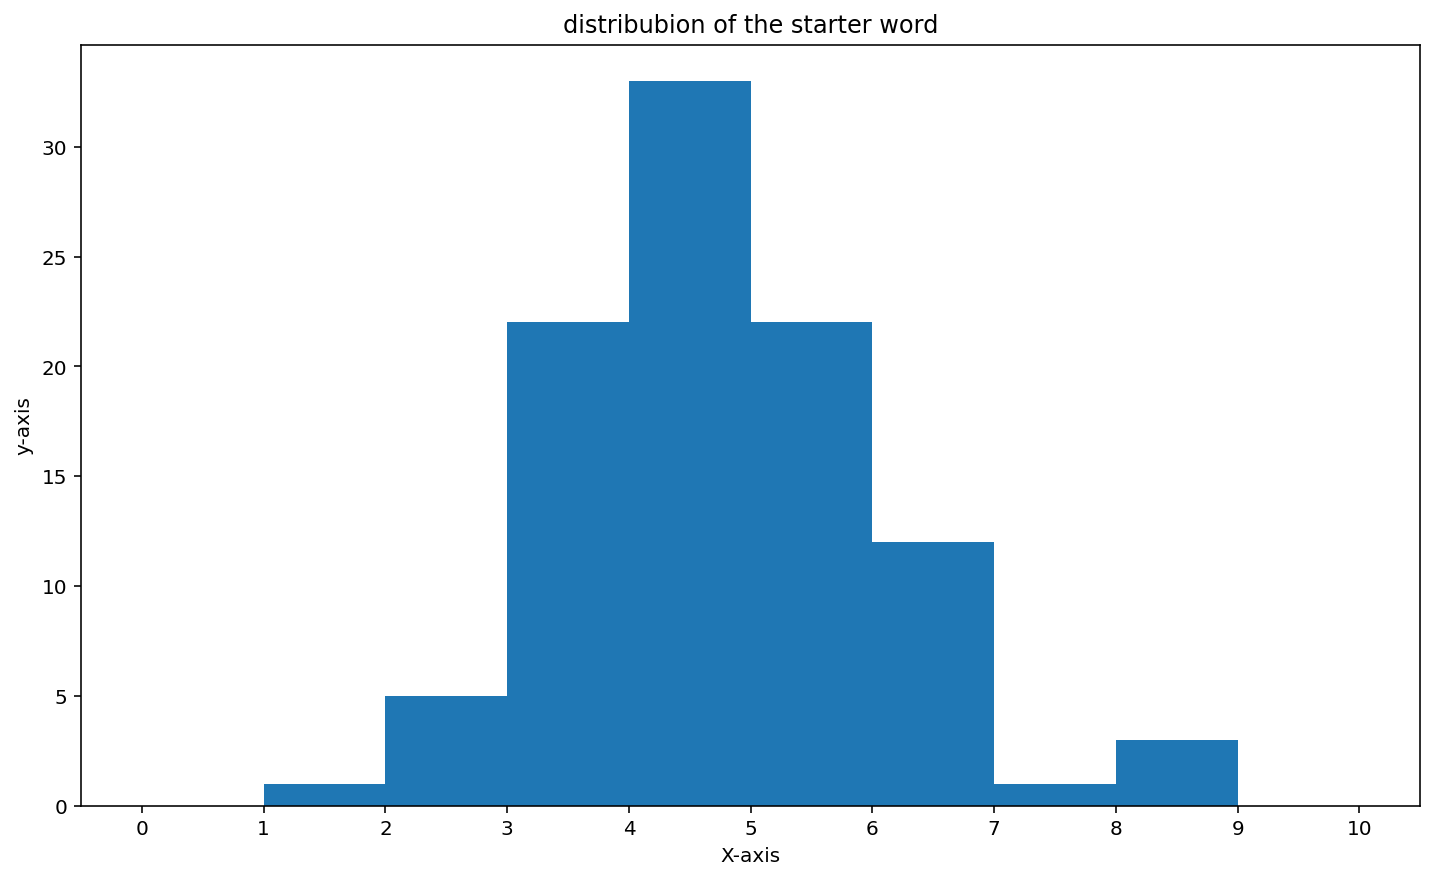

In [83]:
arr = []
for i in range(1,100):
    arr.append(wordle(correct_words[i],'fuzzy'))
print("The average guesses it will take is", sum(arr)/len(arr))
grapher(arr)

The average guesses it will take is 4.414141414141414


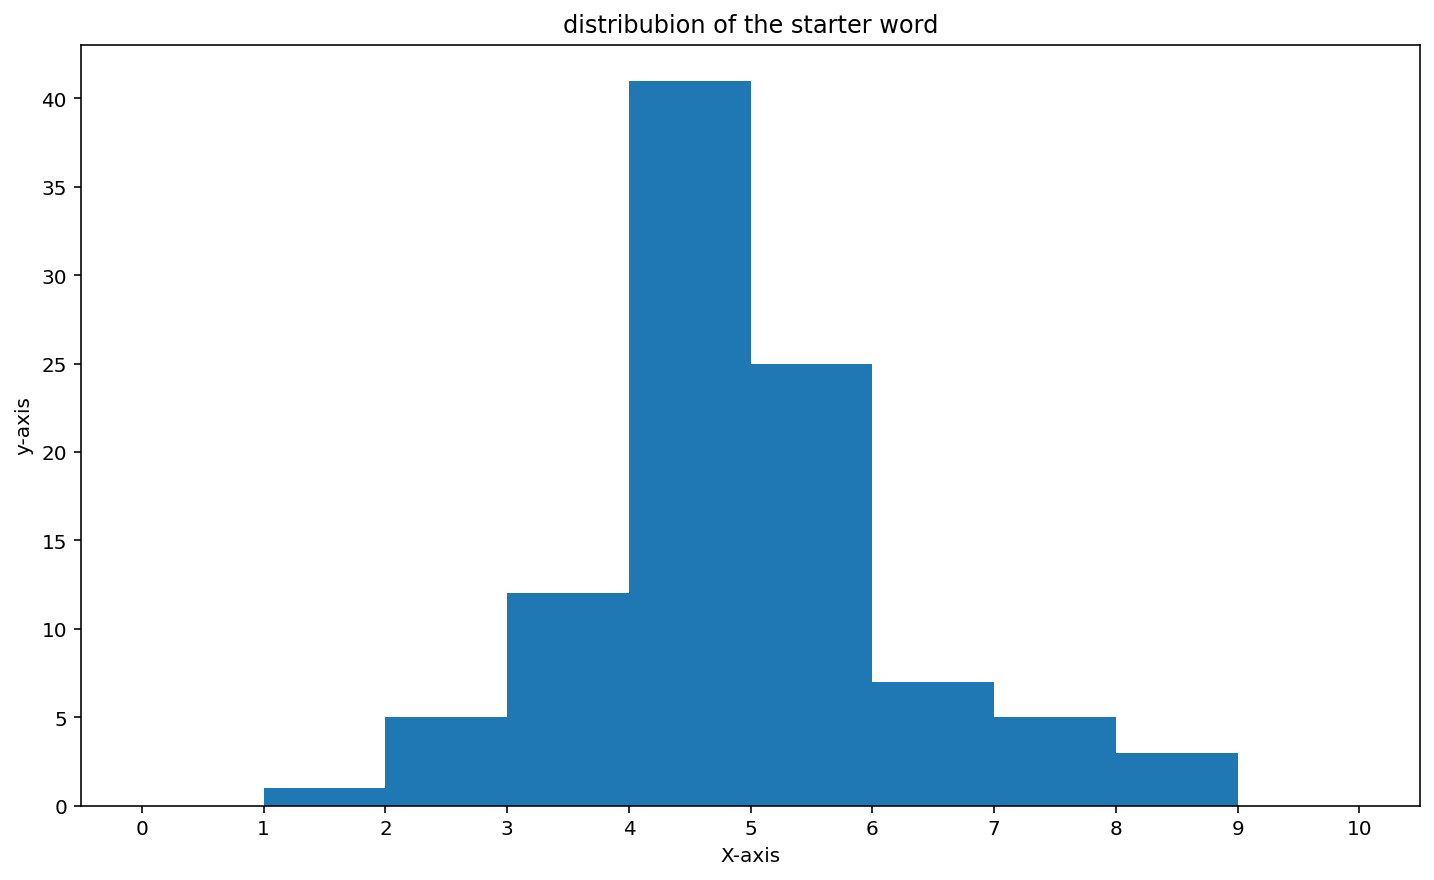

In [84]:
arr = []
for i in range(1,100):
    arr.append(wordle(correct_words[i],'xylyl'))
print("The average guesses it will take is", sum(arr)/len(arr))
grapher(arr)

# Analysis

All the histograms above show us that regardless of the word you start with you can always guess the right word on average of 3-5 guesses. However, this number should be taken with a grain of salt. This is because the bot always know the most optimal second, third etc. guess. For example, lets say you start with "salet" and you get that there exists an L. The next best guess according to the bot is "could". No imagine knowing all 243 most optimal words for every single scenario. Then you need to know the most optimal word for what lights up for "could", and so on. Obviously, this isn't feasible for a human to know, honestly isn't very fun. Instead lets look at what the wordle teaches us. That regardless of how you start, you can always come back, and perform just as well as others. And that doesn't just apply to Wordle.

In [1]:
print("Thanks for your time") 

Thanks for your time


# Extra lessons and tidbits.

This section is just extra functions and comments on the wordle program that I didn't really find a good place to put before my end.

In the code cells below you can have the bot play Wordle for you. Change current to reflect your last most guess, and change info to reflect the matching status of the letters, with 0 being grey, 1 being yellow, and 2 being green. Be sure to run the `all_words = set(orig_all_words)`, before every game as it will reset the active pool of words to every possible word, instead of just the last game's pool.

Have fun testing it against the Wordle archives: https://www.devangthakkar.com/wordle_archive/?230

In [14]:
all_words = set(orig_all_words)

In [16]:
current = 'bonus'
info = (0,2,0,2,2)
words = generate_valid(current,all_words)
words = words[current][info]
all_words = all_words.intersection(words)

choices = generate_valid(current,correct_words)[current][info]
entropies = calc_entropies(choices,all_words)
max_key = max(entropies, key=entropies.get)
print(max_key)

focus


I usually compare the bot's performance against this guy: https://www.youtube.com/c/ScottStrosahl/videos, in case you want a day-to-day metric